In [4]:

import tensorflow as tf
from tensorflow.keras import layers, Model
import cv2
import pandas as pd
import numpy as np

In [5]:


def load_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize the image
    img = img.astype(np.float32) / 255.0
    return img
train_df = pd.read_csv("COMP90086_2023_TLLdataset/train.csv")
test_df = pd.read_csv('COMP90086_2023_TLLdataset/test_candidates.csv')
train_left_images = [load_image(f"COMP90086_2023_TLLdataset/train/left/{img_name}.jpg") for img_name in train_df['left']]
train_right_images = [load_image(f"COMP90086_2023_TLLdataset/train/right/{img_name}.jpg") for img_name in train_df['right']]


from sklearn.model_selection import train_test_split

def create_pairs(left_images, right_images):
    pairs = []
    labels = []

    for i in range(len(left_images)):
        # Positive pairing
        pairs.append([left_images[i], right_images[i]])
        labels.append(1)

        # Negative pairing
        random_idx = np.random.randint(0, len(left_images))
        while random_idx == i:  # Ensure it's not the same image
            random_idx = np.random.randint(0, len(left_images))

        pairs.append([left_images[i], right_images[random_idx]])
        labels.append(0)

    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs(train_left_images, train_right_images)

# Splitting pairs for training
train_pairs = [pairs[:, 0], pairs[:, 1]]



from sklearn.model_selection import train_test_split

# First, combine the pairs and labels for splitting
combined_pairs = list(zip(train_pairs[0], train_pairs[1], labels))

# Split the data into train (90%) and temp (10%)
train_temp, temp_data = train_test_split(combined_pairs, test_size=0.1, random_state=21, stratify=labels)

# Split the temp data into validation (50%) and test (50%)
val_temp, test_temp = train_test_split(temp_data, test_size=0.5, random_state=21, stratify=[label for _, _, label in temp_data])

# Extract left images, right images, and labels back from the combined data for each set
def extract_data(data_temp):
    left_images = [item[0] for item in data_temp]
    right_images = [item[1] for item in data_temp]
    labels_temp = [item[2] for item in data_temp]
    return [np.array(left_images), np.array(right_images)], np.array(labels_temp)

train_data, train_labels = extract_data(train_temp)
val_data, val_labels = extract_data(val_temp)
test_data, test_labels = extract_data(test_temp)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.experimental.AUTOTUNE
TARGET_SIZE = (224, 224)



def augment_image(img):
    # Randomly apply horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # Randomly apply vertical flip
    img = tf.image.random_flip_up_down(img)
    
    # Randomly change brightness
    img = tf.image.random_brightness(img, max_delta=0.3)
    
    # Randomly change contrast
    img = tf.image.random_contrast(img, lower=0.7, upper=1.3)
    
    # Make sure the image is still in [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    
    return img

def load_and_preprocess_image(img_path, augment=False):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = img / 255.0  # Normalize to [0,1]
    
    # Apply data augmentation if specified
    if augment:
        img = augment_image(img)
    
    return img

def create_pairs_tf(left_images, right_images, labels, augment=False):
    def _load_img_pairs(left_path, right_path, label):
        left_img = load_and_preprocess_image(left_path, augment)
        right_img = load_and_preprocess_image(right_path, augment)
        return (left_img, right_img), label

    dataset = tf.data.Dataset.from_tensor_slices((left_images, right_images, labels))
    dataset = dataset.map(_load_img_pairs, num_parallel_calls=AUTOTUNE)
    return dataset



train_df = pd.read_csv("COMP90086_2023_TLLdataset/train.csv")

left_image_paths = [f"COMP90086_2023_TLLdataset/train/left/{img_name}.jpg" for img_name in train_df['left']]
right_image_paths = [f"COMP90086_2023_TLLdataset/train/right/{img_name}.jpg" for img_name in train_df['right']]

# Positive samples' labels
positive_labels = [1] * len(left_image_paths)

# Negative samples: Matching left paths with random permutations of the right paths
negative_left_paths = left_image_paths
negative_right_paths = np.random.permutation(right_image_paths).tolist()

# Negative samples' labels
negative_labels = [0] * len(negative_left_paths)

# Combine positive and negative samples
all_left_paths = left_image_paths + negative_left_paths
all_right_paths = right_image_paths + negative_right_paths
all_labels = positive_labels + negative_labels

# Split into training and validation
left_train_paths, left_val_paths, right_train_paths, right_val_paths, labels_train, labels_val = train_test_split(
    all_left_paths, all_right_paths, all_labels, test_size=0.1, stratify=all_labels
)

# Create datasets for training and validation
train_dataset = create_pairs_tf(left_train_paths, right_train_paths, labels_train,augment=True)
val_dataset = create_pairs_tf(left_val_paths, right_val_paths, labels_val,labels_train)

# Batching and Prefetching
BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def cosine_similarity_tensors(vectors):
    x, y = vectors
    x = tf.keras.backend.l2_normalize(x, axis=-1)
    y = tf.keras.backend.l2_normalize(y, axis=-1)
    return tf.keras.backend.sum(x * y, axis=-1, keepdims=True)

def siamese_with_dense121_and_cosine_similarity(input_shape):
    left_input = layers.Input(input_shape)
    right_input = layers.Input(input_shape)

    # Use DenseNet121 as the base model
    base_model = tf.keras.applications.DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights('densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')
    for layer in base_model.layers:
        layer.trainable = False
    n = 10
    for layer in base_model.layers[-n:]:
        layer.trainable = True

    encoded_left = base_model(left_input)
    encoded_right = base_model(right_input)

    # Flatten the encoded outputs (or you can add more layers if needed)
    encoded_left = layers.Flatten()(encoded_left)
    encoded_right = layers.Flatten()(encoded_right)

    # Use cosine similarity to compute the similarity score
    similarity_score = layers.Lambda(cosine_similarity_tensors)([encoded_left, encoded_right])

    siamese_net = Model(inputs=[left_input, right_input], outputs=similarity_score)
    return siamese_net

input_shape = (224, 224, 3)  # Default input shape for DenseNet121
model_dense121 = siamese_with_dense121_and_cosine_similarity(input_shape)
model_dense121.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_dense121.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
225/225 [==============================] - 143s 619ms/step - loss: 0.6953 - accuracy: 0.5422 - val_loss: 0.6762 - val_accuracy: 0.5600
Epoch 2/5
 62/225 [=======>......................] - ETA: 1:30 - loss: 0.6667 - accuracy: 0.5796

KeyboardInterrupt: 

7/7 [==============================] - 8s 947ms/step


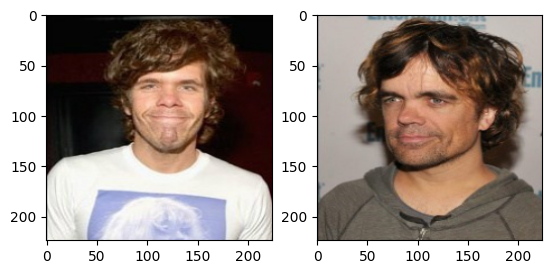

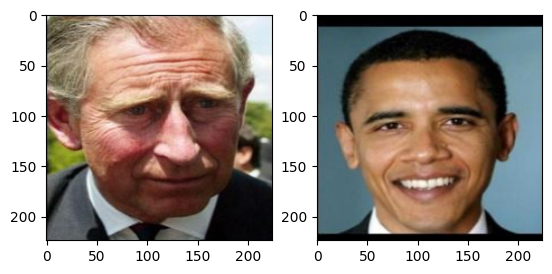

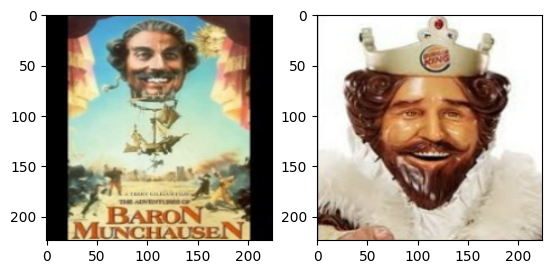

In [6]:
predictions = model_dense121.predict([val_data[0], val_data[1]])

binary_predictions = (predictions > 0.5).astype(int)
incorrect_indices = np.where(binary_predictions.squeeze() != val_labels)[0]
# Select the first 3 pairs of images with wrong classifications
selected_indices = incorrect_indices[:3]

incorrect_pairs = [(val_data[0][index], val_data[1][index]) for index in selected_indices]
import matplotlib.pyplot as plt

for pair in incorrect_pairs:
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(pair[0])
    axes[1].imshow(pair[1])
    plt.show()


In [19]:
def extend_validation_data(val_left, val_right, all_right_images):
    extended_val_left = []
    extended_val_right = []
    labels = []
    
    for left_img, right_img in zip(val_left, val_right):
        # Add the correct pair
        extended_val_left.append(left_img)
        extended_val_right.append(right_img)
        labels.append(1)  # Correct pair
        
        # Add 19 random images
        random_indices = np.random.choice(len(all_right_images), 19, replace=False)
        for idx in random_indices:
            extended_val_left.append(left_img)
            extended_val_right.append(all_right_images[idx])
            labels.append(0)  # Incorrect pair

    return np.array(extended_val_left), np.array(extended_val_right), np.array(labels)

val_left_extended, val_right_extended, extended_labels = extend_validation_data(test_data[0], test_data[1], train_right_images)

similarity_scores_val = model_dense121.predict([val_left_extended, val_right_extended])

def calculate_top_2_accuracy_for_validation(similarity_scores, labels, batch_size=20):
    correct_predictions = 0
    total_predictions = len(similarity_scores) // batch_size
    
    for i in range(total_predictions):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        subset_scores = similarity_scores[start_idx:end_idx]
        
        top_2_indices = subset_scores.argsort()[-2:][::-1]
        
        # Check if the top 2 highest-confidence predictions match the ground truth
        if labels[start_idx + top_2_indices[0]] == 1 or labels[start_idx + top_2_indices[1]] == 1:
            correct_predictions += 1

    top_2_accuracy = correct_predictions / total_predictions
    return top_2_accuracy

top_2_acc_val = calculate_top_2_accuracy_for_validation(similarity_scores_val, extended_labels)
print(f"Test Top-2 Accuracy: {top_2_acc_val * 100:.2f}%")


125/125 [==============================] - 138s 1s/step
Test Top-2 Accuracy: 100.00%


In [33]:

EPOCHS = 5
history = model_dense121.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)



Epoch 1/5
225/225 [==============================] - 134s 595ms/step - loss: 0.6869 - accuracy: 0.5486 - val_loss: 0.6705 - val_accuracy: 0.5825
Epoch 2/5
225/225 [==============================] - 133s 591ms/step - loss: 0.6615 - accuracy: 0.5822 - val_loss: 0.6577 - val_accuracy: 0.5875
Epoch 3/5
225/225 [==============================] - 131s 580ms/step - loss: 0.6472 - accuracy: 0.6142 - val_loss: 0.6447 - val_accuracy: 0.6000
Epoch 4/5
225/225 [==============================] - 132s 588ms/step - loss: 0.6377 - accuracy: 0.6300 - val_loss: 0.6251 - val_accuracy: 0.6525
Epoch 5/5
225/225 [==============================] - 132s 587ms/step - loss: 0.6315 - accuracy: 0.6492 - val_loss: 0.6265 - val_accuracy: 0.6425


In [7]:
# Save the entire model
model_dense121.save('my_model_dense121.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Later, to restore:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model_dense121.h5')


In [9]:
def load_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize the image
    img = img.astype(np.float32) / 255.0
    return img

def predict_similarity1(left_img, right_img):
    return model_dense121.predict([np.array([left_img]), np.array([right_img])])[0][0]

predictions = []
i = 0
# Iterate through each row in the test dataframe
for _, row in test_df.iterrows():
    left_img = load_image(f"COMP90086_2023_TLLdataset/test/left/{row['left']}.jpg")
    confidences = []

    # Predict the similarity score for each candidate "right" image
    for i in range(20): # Assuming there are 20 candidates for each "left" image
        right_img = load_image(f"COMP90086_2023_TLLdataset/test/right/{row[f'c{i}']}.jpg")
        confidences.append(predict_similarity1(left_img, right_img))
    if i % 100 == 0:
        print(f"Processed {i} rows")
    i += 1
    predictions.append(confidences)

# Create a DataFrame to store the predictions
submission_df = pd.DataFrame(predictions, columns=[f'c{i}' for i in range(20)])

submission_df['left'] = test_df['left']

# Rearrange columns to put 'left' at the beginning
cols = ['left'] + [col for col in submission_df if col != 'left']
submission_df = submission_df[cols]
# Write the DataFrame to a CSV file
submission_df.to_csv('kaggle_submission_updated_aug.csv', index=False)



1/1 [==============================] - 0s 84ms/step


KeyboardInterrupt: 

In [26]:
# 1. 准备测试数据
test_df = pd.read_csv("COMP90086_2023_TLLdataset/test_candidates.csv")

left_test_paths = [f"COMP90086_2023_TLLdataset/test/left/{img_name}.jpg" for img_name in test_df['left']]
right_test_paths = [f"COMP90086_2023_TLLdataset/test/right/{img_name}.jpg" for img_name in test_df['right']]
test_labels = [1] * len(left_test_paths)  # 假设所有的对都是正样本

test_dataset = create_pairs_tf(left_test_paths, right_test_paths, test_labels)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


# 3. 评估模型
loss, accuracy = model_dense121.evaluate(test_dataset)
print(f"Test accuracy: {accuracy * 100:.2f}%")


KeyError: 'right'